# CMPINF011 Final
This is my section, which I will be focusing on transit part of infrastructure. Specifically, I will be focusing on the efficiency (on-timeness) of transite routes in different neighborhoods. -Alex Jin

## On Time Performance (OTP)
Since most commuter’s way of travel will be via bus (especially university students), it is essential for them to be on time, so commuters can schedule accordingly and not arrive later, or too early than they are supposed to. This dataset collects the "on time performance" percentage of each route; which is the "fraction of timepoints that the transit vehicle departed on time from the stop", according to the data dictionary.

By categorizing each route into a neighborhood, we can analyze which neighborhood has the highest on time performance.

### Gathering Data and Filtering
I am using the dataset provided [here](https://data.wprdc.org/dataset/port-authority-monthly-average-on-time-performance-by-route/resource/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a), which is licensed under CC-BY.

I am using only data from weekday services, excluding weekends and special dates (Christmas, Memorial Day, etc). I am also using data starting since 2024-01, so it is the most recent.

In [ ]:
otp_dataset = pd.read_csv("https://data.wprdc.org/datastore/dump/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a")
otp_dataset["month_start"] = pd.to_datetime(otp_dataset["month_start"])
weekday_otp = otp_dataset\
    [(otp_dataset["year_month"] >= 202401) & (otp_dataset["day_type"] == "WEEKDAY")]\
    .drop("ridership_route_code", axis=1)\
    .drop("data_source", axis=1)
# weekday_otp.info()

### Categorizing Routes
Since the dataset does not have a column for the neighborhood it goes through, I manually created keywords to categorize different routes by name into neighborhoods.

For convenience of coming to the conclusion of the best neighborhood, I also used the same list of neighborhood by the previous metric; that is:

In [ ]:
keywords = {
    "Squirrel Hill": ["SQUIRREL HILL"],
    "Hays": ["LINCOLN PLACE"],
    "Highland Park": ["HIGHLAND PARK"],
    "Mount Washington": ["MOUNT WASHINGTON"],
    "Beechview": ["BEECHVIEW"],
    "Perry North": ["PERRYSVILLE"],
    "Hazelwood": ["HAZELWOOD"],
    "Sheriden": ["CHARTIERS", "FAIRYWOOD"],
    "South Side": ["SOUTH SIDE"],
    "Allegheny Center": ["NORTH SIDE"]
}

Then, I wrote a small helper function to help categorize different routes with the dictionary.

In [ ]:
def get_neighborhood(route_name):
    route_upper = str(route_name).upper()
    for hood, keys in keywords.items():
        for key in keys:
            if key in route_upper:
                return hood
    pass

Finally, after categorizing each route into a neighborhood, I can calculate the average OTP for each neighborhood.

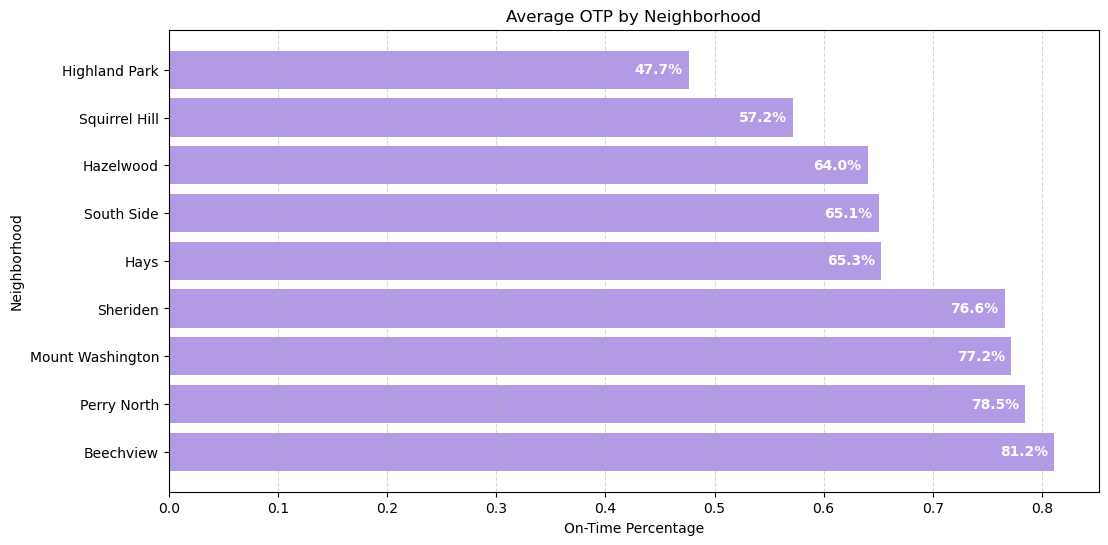

In [ ]:
weekday_otp["assigned_neighborhood"] = weekday_otp["route_full_name"].apply(get_neighborhood) # applying the helper function
mapped_data = weekday_otp[weekday_otp["assigned_neighborhood"].notnull()] # filter with only matches
assignments = mapped_data[["route_full_name", "assigned_neighborhood"]].drop_duplicates().sort_values("assigned_neighborhood") # assigned routes to neighborhood
hood_stats = mapped_data.groupby("assigned_neighborhood")["on_time_percent"].mean().reset_index().sort_values("on_time_percent", ascending=False) # calculating metrics for these neighborhoods

# print("assignments:\n", assignments)
# print("\nperformance stats:\n", hood_stats)

plt.figure(figsize=(12, 6))
bars = plt.barh(hood_stats["assigned_neighborhood"], hood_stats["on_time_percent"], color="mediumpurple", alpha = 0.7)
plt.title("Average OTP by Neighborhood")
plt.xlabel("On-Time Percentage")
plt.ylabel("Neighborhood")
plt.grid(axis="x", linestyle="--", alpha=0.5)

# add OTP label in percentage
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.05, bar.get_y() + bar.get_height() / 2, f"{width:.1%}", va="center", fontsize=10, color="white", fontweight="bold")

plt.show()

From the chart, we can see that **Beechview** have the highest OTP for all the transit routes in that area.

### Extra: Graphs and Charts
Just for fun, I have created some extra visualizations. This one shows the average OTP over time, from 2017 to the data cutoff (later 2024).

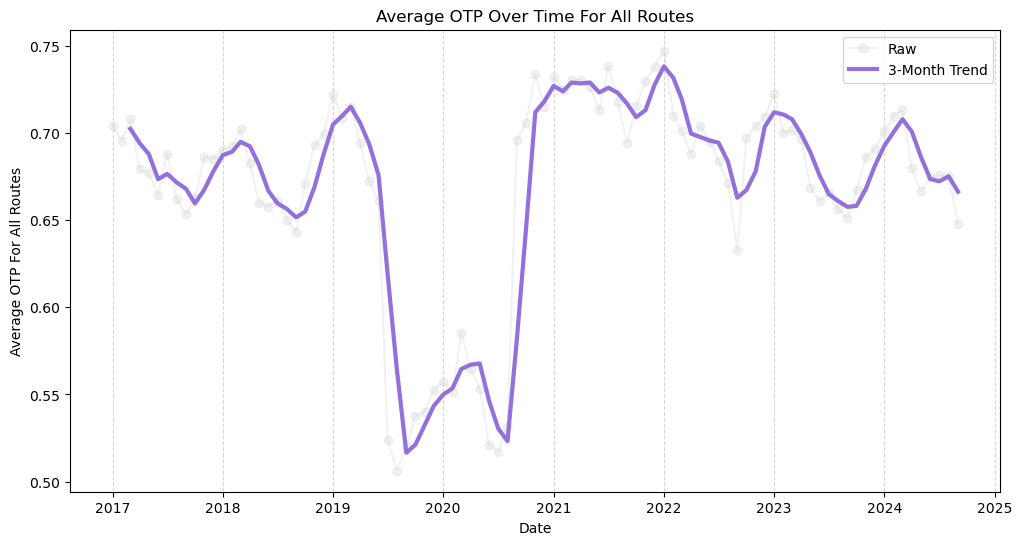

In [ ]:
monthly_avg = otp_dataset.groupby("month_start")["on_time_percent"].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg["month_start"], monthly_avg["on_time_percent"], label="Raw", marker="o", linestyle="-", color="lightgray", alpha=0.3)
plt.title("Average OTP Over Time For All Routes")
plt.xlabel("Date")
plt.ylabel("Average OTP For All Routes")
plt.grid(axis="x", linestyle="--", alpha=0.5)

monthly_avg["rolling_avg"] = monthly_avg["on_time_percent"].rolling(window=3).mean()
plt.plot(monthly_avg["month_start"], monthly_avg["rolling_avg"], linewidth=3, color="mediumpurple", label="3-Month Trend")

plt.legend()
plt.show()

This chart shows the top 10 most reliable routes — that is, having the highest OTP.

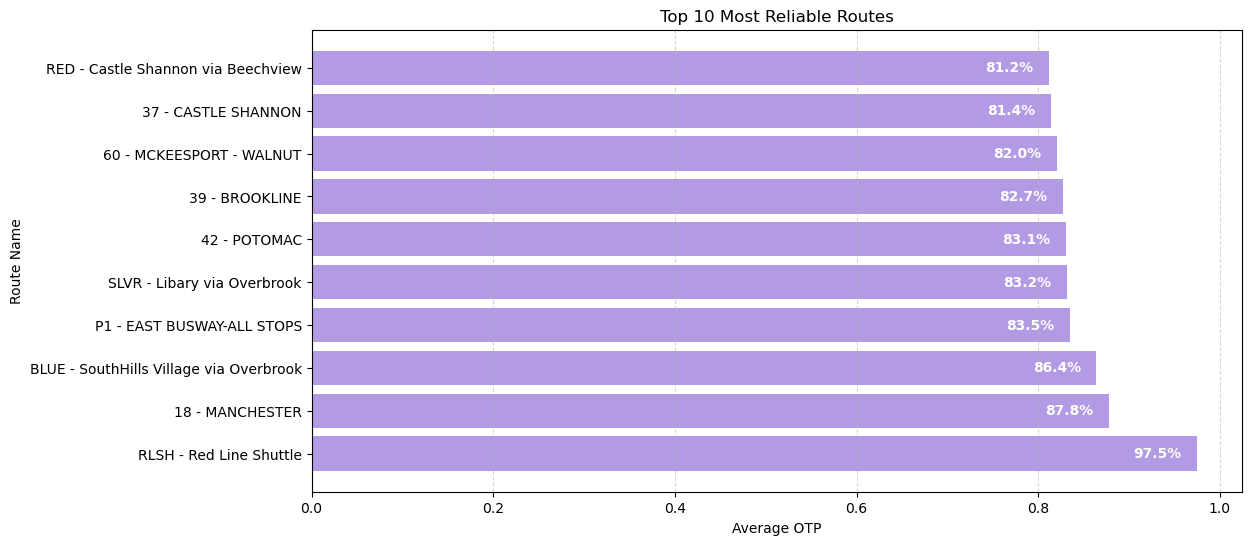

In [ ]:
top10_routes = weekday_otp.groupby("route_full_name")["on_time_percent"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(top10_routes.index, top10_routes.values, color="mediumpurple", alpha=0.7)
plt.title("Top 10 Most Reliable Routes")
plt.xlabel("Average OTP")
plt.ylabel("Route Name")
plt.grid(axis="x", linestyle="--", alpha=0.5)

for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.07, bar.get_y() + bar.get_height() / 2, f"{width:.1%}", va="center", fontsize=10, color="white", fontweight="bold")

plt.show()

This historgram shows the distribution of OTP over all routes. Since it is normalized already, we can see that it is actually a normal distribution! In addition to plotting the density, I also added a line that shows the normal distribution:

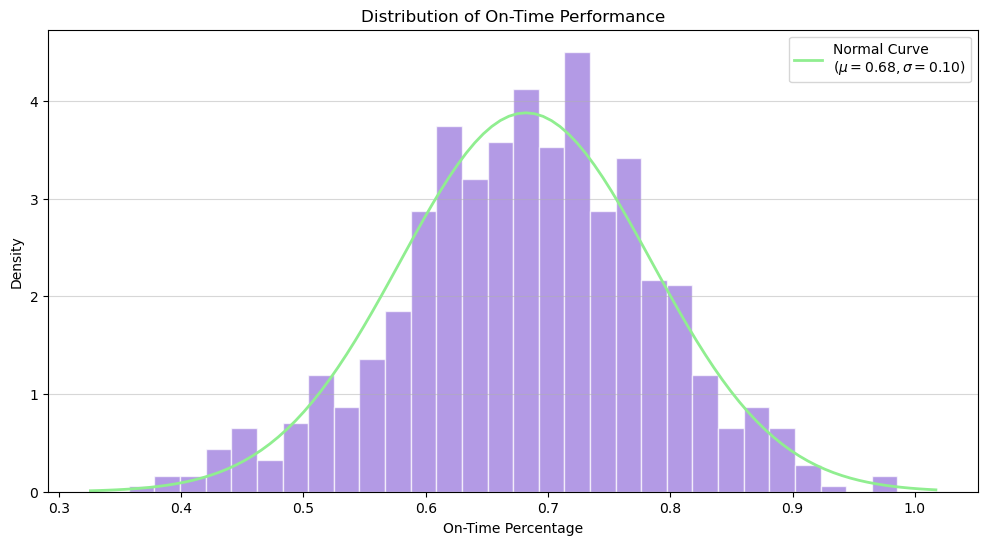

In [ ]:
plt.figure(figsize=(12, 6))

# standard distribution
mu = weekday_otp["on_time_percent"].mean()
sigma = weekday_otp["on_time_percent"].std()

# plot
plt.hist(weekday_otp["on_time_percent"], density=True, bins=30, color="mediumpurple", edgecolor="white", alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, linewidth=2, label=f"Normal Curve \n($\\mu={mu:.2f}, \\sigma={sigma:.2f}$)", color="lightgreen")
plt.legend()
plt.title("Distribution of On-Time Performance")
plt.xlabel("On-Time Percentage")
plt.ylabel("Density")
plt.grid(axis="y", alpha=0.5)
plt.show()